# Explore missing data for remote sensing data, impute

In [52]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial.distance import pdist, squareform

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
os.chdir("/content/drive/MyDrive/CHVI")

In [54]:
path="1_Data/Remote_Sensing/Raw"

In [55]:
os.listdir(path)

['ndvi_10kmx10km_grid.gpkg',
 'ndwi_10kmx10km_grid.gpkg',
 'ndbi_10kmx10km_grid.gpkg',
 'individual_files',
 'lulc_10kmx10km_grid.gpkg',
 'lulc_10kmx10km_grid_enhanced.gpkg']

In [ ]:
# import remote sensing files

ndvi=gpd.read_file(f"{path}/ndvi_10kmx10km_grid.gpkg")
ndbi=gpd.read_file(f"{path}/ndbi_10kmx10km_grid.gpkg")
ndwi=gpd.read_file(f"{path}/ndwi_10kmx10km_grid.gpkg")
lulc=gpd.read_file(f"{path}/lulc_10kmx10km_grid.gpkg")

In [86]:
lulc.columns

Index(['C_CODE11', 'DISTRICT', 'Date', 'NAME', 'bare', 'built', 'crops',
       'flooded_vegetation', 'grass', 'grid_id', 'shrub_and_scrub',
       'snow_and_ice', 'trees', 'water', 'urbanization_index',
       'surface_water_fraction', 'agriculture_fraction', 'vegetation_cover',
       'nonhabitat_fraction', 'geometry'],
      dtype='object')

In [87]:
lulc_filt=lulc[['C_CODE11', 'DISTRICT', 'Date', 'NAME','urbanization_index',
       'geometry', 'grid_id' ]]

In [94]:
for df in [ndvi, ndbi, ndwi, lulc_filt]:
    df["C_CODE11"]=df["C_CODE11"].astype(int)
    df["Date"]=pd.to_datetime(df["Date"])

/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
ndvi[ndvi["NDVI"].isna()]["grid_id"].unique()

# Missing EDA

# 1. Overall Missing Fraction
- 13-14% which needs imputation, but can be handled

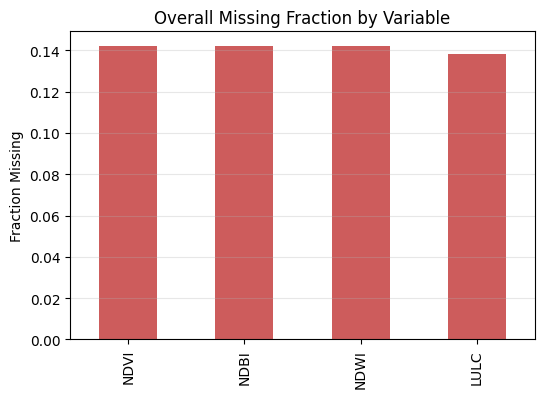

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine basic missingness info
summary = pd.DataFrame({
    'NDVI': ndvi['NDVI'].isna().mean(),
    'NDBI': ndbi['NDBI'].isna().mean(),
    'NDWI': ndwi['NDWI'].isna().mean(),
    'LULC': lulc_filt[['urbanization_index', 'surface_water_fraction',
                       'agriculture_fraction', 'vegetation_cover', 'nonhabitat_fraction']].isna().mean().mean()
}, index=['Missing Fraction']).T

summary.plot(kind='bar', legend=False, figsize=(6,4), color='indianred')
plt.title("Overall Missing Fraction by Variable")
plt.ylabel("Fraction Missing")
plt.grid(axis='y', alpha=0.3)
plt.show()


# Temporal missingness
- Missingness peaks during certain months → July & August (and a little bit in September) -  monsoon/cloud-driven → use spatial interpolation (kriging).
- Long continuous gaps → temporal interpolation unreliable → use spatial neighbors or spatio-temporal kriging.

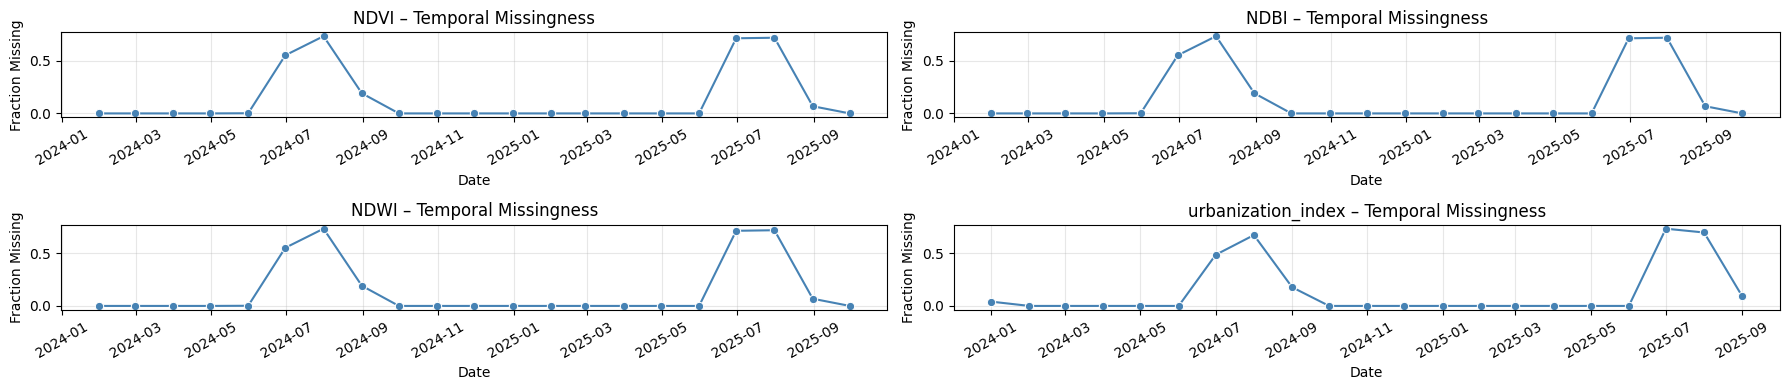

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_temporal_missing(df, var, ax):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    temp = df.groupby('Date')[var].apply(lambda x: x.isna().mean()).reset_index()
    sns.lineplot(data=temp, x='Date', y=var, ax=ax, marker='o', color='steelblue')
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(f"{var} – Temporal Missingness")
    ax.set_ylabel("Fraction Missing")
    ax.set_xlabel("Date", rotation=0)
    ax.grid(alpha=0.3)

# Create subplots for NDVI, NDBI, NDWI, and LULC
fig, axes = plt.subplots(2, 2, figsize=(18, 4))

plot_temporal_missing(ndvi, 'NDVI', axes[0][0])
plot_temporal_missing(ndbi, 'NDBI', axes[0][1])
plot_temporal_missing(ndwi, 'NDWI', axes[1][0])
plot_temporal_missing(lulc_filt, 'urbanization_index', axes[1][1])
plt.tight_layout()
plt.show()



In [85]:
ndvi.columns, ndbi.columns, ndwi.columns, lulc_filt.columns

(Index(['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDVI', 'source', 'Date',
        'geometry'],
       dtype='object'),
 Index(['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDBI', 'source', 'Date',
        'geometry'],
       dtype='object'),
 Index(['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDWI', 'source', 'Date',
        'geometry'],
       dtype='object'),
 Index(['C_CODE11', 'DISTRICT', 'Date', 'NAME', 'urbanization_index',
        'surface_water_fraction', 'agriculture_fraction', 'vegetation_cover',
        'nonhabitat_fraction', 'geometry'],
       dtype='object'))

#

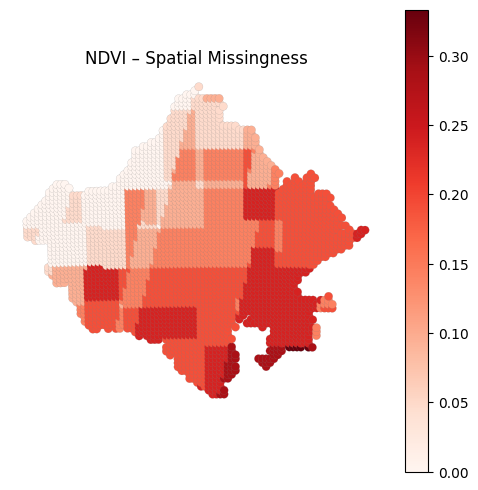

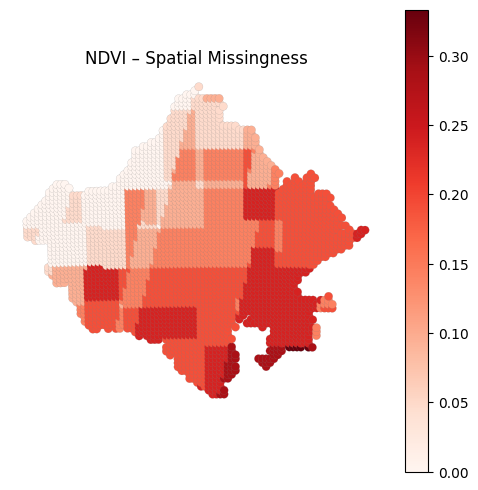

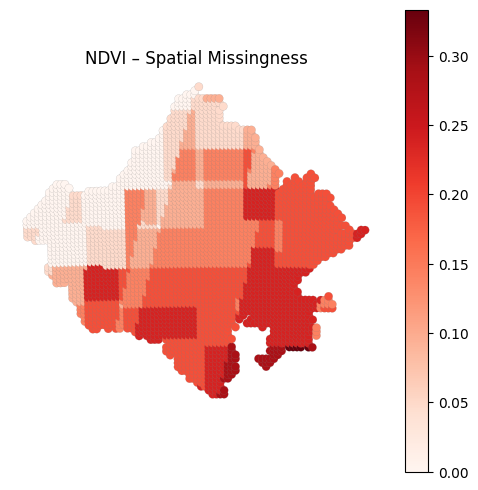

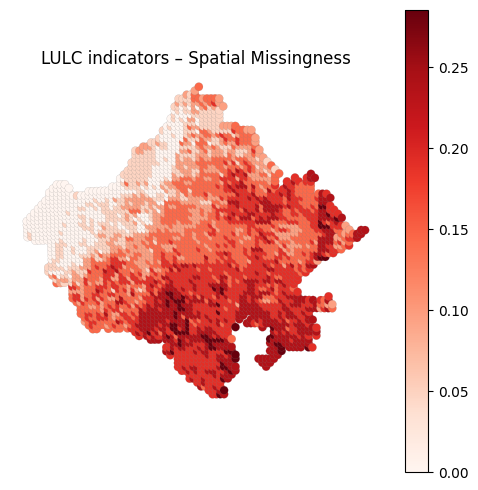

In [88]:
import geopandas as gpd

def plot_spatial_missing(gdf, var, title):
    temp = gdf.groupby('grid_id')[var].apply(lambda x: x.isna().mean()).reset_index()
    merged = gdf[['grid_id', 'geometry']].drop_duplicates().merge(temp, on='grid_id', how='left')
    fig, ax = plt.subplots(figsize=(6,6))
    merged.plot(column=var, cmap='Reds', legend=True, ax=ax, edgecolor='gray', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')

plot_spatial_missing(ndvi, 'NDVI', 'NDVI – Spatial Missingness')

plot_spatial_missing(ndbi, 'NDBI', 'NDVI – Spatial Missingness')

plot_spatial_missing(ndwi, 'NDWI', 'NDVI – Spatial Missingness')

plot_spatial_missing(lulc_filt, 'urbanization_index', 'LULC indicators – Spatial Missingness')


In [63]:
lulc_filt.columns

Index(['C_CODE11', 'DISTRICT', 'Date', 'NAME', 'urbanization_index',
       'surface_water_fraction', 'agriculture_fraction', 'vegetation_cover',
       'nonhabitat_fraction', 'geometry'],
      dtype='object')